In [23]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
%matplotlib inline

# 0. Functions

In [11]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [204]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    return meds, maxs

In [92]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 10000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)

## (a) Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [4]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
ratios = XY.loc[:, lbls].copy()

In [5]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

## (b) Get test sample for LL calcs

In [161]:
# Choosing PHWR sample intentionally
sim_idx = 65331
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65331,phwr,1883.227187,0.711,3383.22,candu37


## (c) LL calcs for uncertainty = 2.8%, 5.6%, 8.4%, 11.2%

In [162]:
fullXY = ratios.loc[ratios['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [163]:
uncs = [0.028, 0.056, 0.084, 0.112]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

## (d) Half trainset + full trainset

In [209]:
trainXY = fullXY.sample(frac=0.5)

# 2. LogLikelihood for 3 reactors with Uncertainty = 11%

In [211]:
ll = 'LogLikelihood_0.112'
zname = [ll, ll, ll, ll]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

## (a) Half trainset

In [212]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll)
plotXY1 = trainXY_pwr.loc[trainXY_pwr[ll] > meds[0]]
plotXY2 = trainXY_agr.loc[trainXY_agr[ll] > meds[1]]
plotXY3 = trainXY_phwr.loc[trainXY_phwr[ll] > meds[2]]
plotXY4 = trainXY.loc[trainXY[ll] > meds[3]]

PWR Median: -111.41885564399067 
 Stats: DescribeResult(nobs=17128, minmax=(-397904.00803759915, -25.617646367621308), mean=-1585.491814595618, variance=119090911.12019084, skewness=-21.735732683883462, kurtosis=587.8947552989728) 

AGR Median: -132.61282108280176 
 Stats: DescribeResult(nobs=8502, minmax=(-215125.66336201038, -15.612167586305018), mean=-1068.295698207499, variance=31747171.391649447, skewness=-17.680377149733495, kurtosis=476.5472178688267) 

PHWR Median: -127.89776853874581 
 Stats: DescribeResult(nobs=10943, minmax=(-49156614.78426867, 43.5992616241531), mean=-1083268.0047215722, variance=26799437564904.1, skewness=-5.06205132406697, kurtosis=25.335948557044002) 

All Median: -119.74418213402492 
 Stats: DescribeResult(nobs=36573, minmax=(-49156614.78426867, 43.5992616241531), mean=-325115.2689004106, variance=8263625774279.604, skewness=-9.617109774906051, kurtosis=95.89714825635485) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


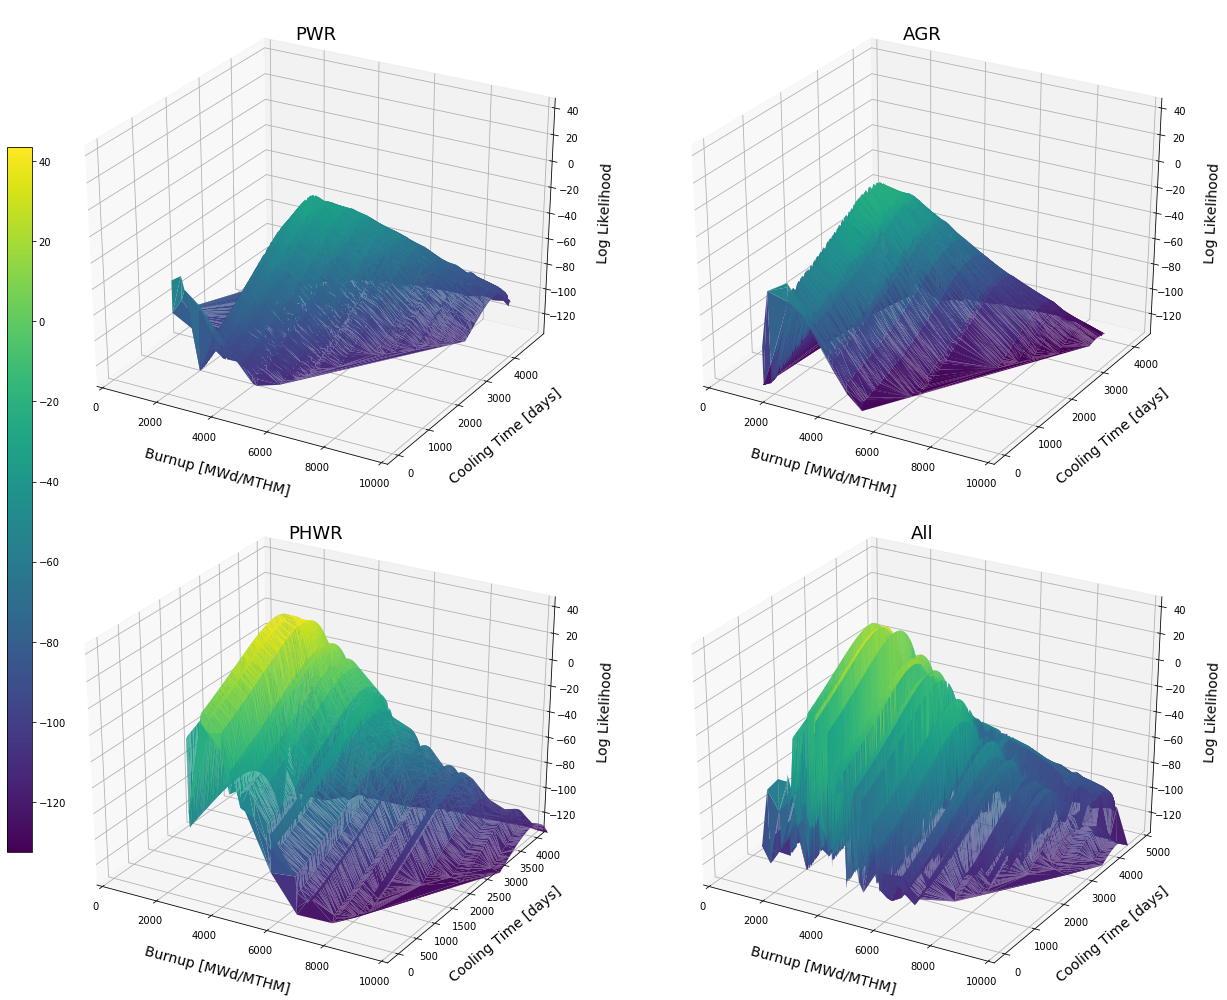

In [213]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

## (b) Full trainset

In [180]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


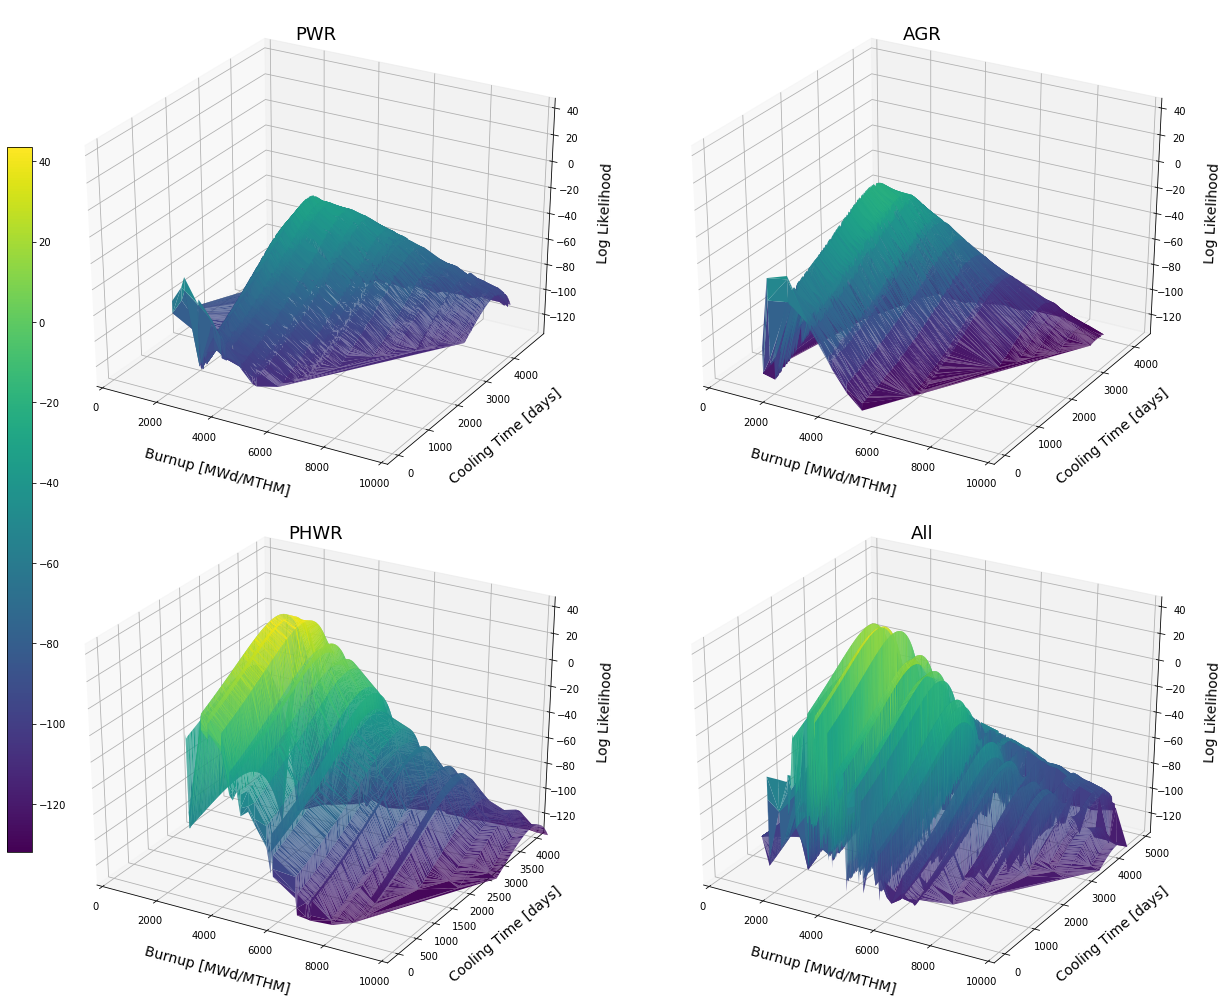

In [181]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [186]:
ll1 = 'LogLikelihood_0.028'
ll2 = 'LogLikelihood_0.056'
ll3 = 'LogLikelihood_0.084'
ll4 = 'LogLikelihood_0.112'
zname = [ll1, ll2, ll3, ll4]
uncss = ['2.8% Unc', '5.6% Unc', '8.4% Unc', '11.2% Unc']

## (a) Half trainset

In [191]:
meds, maxs = getstats_unc(trainXY, ll1, ll2, ll3, ll4)

2.8% Median: -2420.5205523600816 
 Stats: DescribeResult(nobs=36573, minmax=(-716028293.3265944, 57.45131447752493), mean=-5415568.148722976, variance=2215301392002833.2, skewness=-9.41628678258724, kurtosis=91.5635468171626) 

5.6% Median: -576.0898788076613 
 Stats: DescribeResult(nobs=36573, minmax=(-179007015.4039895, 50.521789914905646), mean=-1353858.7743858814, variance=138456280080753.7, skewness=-9.416287234338604, kurtosis=91.56355602923779) 

8.4% Median: -237.45823344109482 
 Stats: DescribeResult(nobs=36573, minmax=(-79558633.37455231, 46.46763371934429), mean=-601693.1427760547, variance=27349369919052.48, skewness=-9.41628798724485, kurtosis=91.56357138253381) 

11.2% Median: -120.39907889287622 
 Stats: DescribeResult(nobs=36573, minmax=(-44751701.121942155, 43.5992616241531), mean=-338436.62940546166, variance=8653503275234.882, skewness=-9.416289041286955, kurtosis=91.56359287680694) 



In [194]:
cutoff = -1000

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


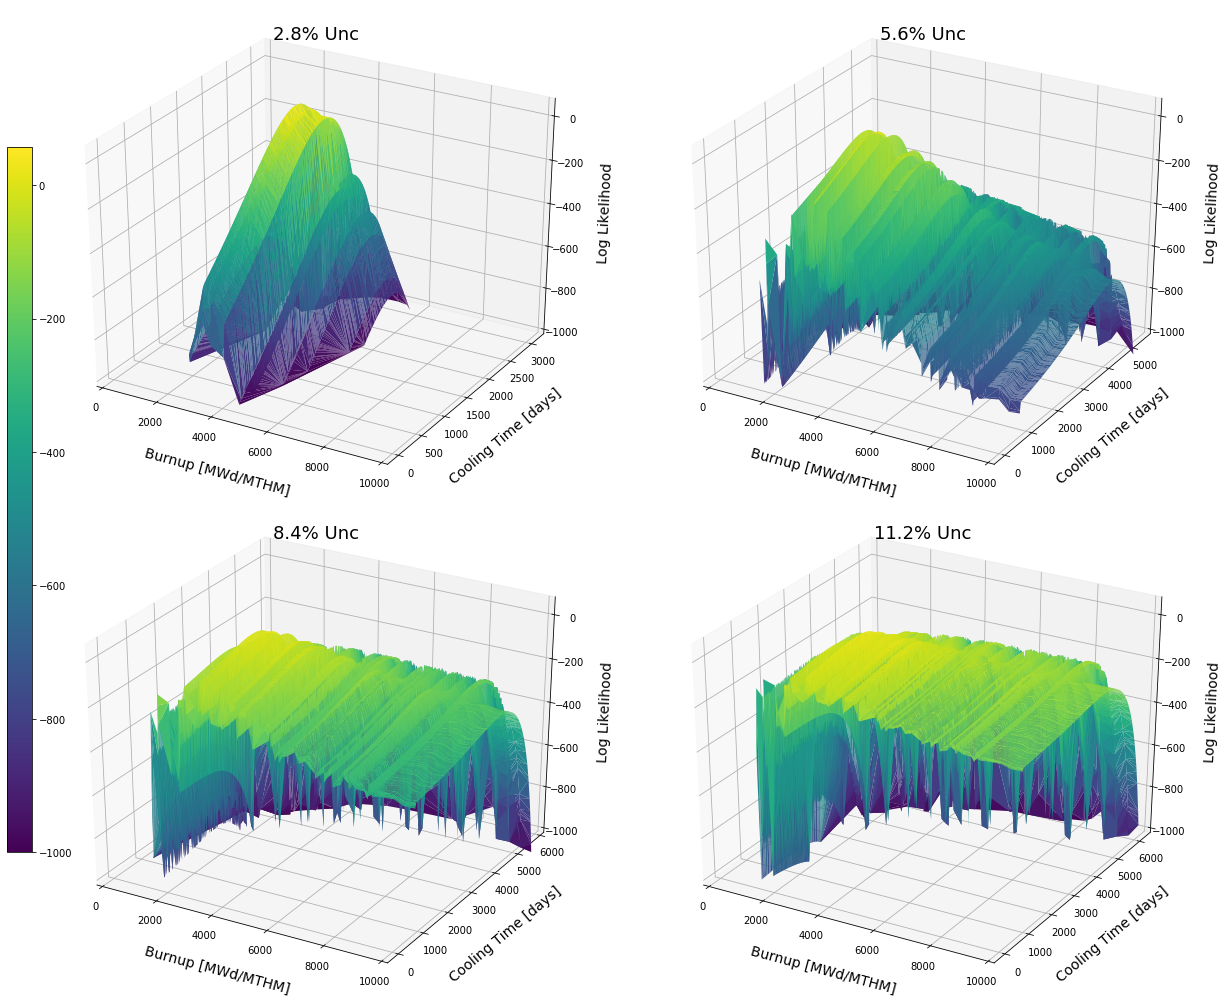

In [195]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))

## (b) Full trainset

In [196]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -2417.885353193109 
 Stats: DescribeResult(nobs=73146, minmax=(-786506914.9065645, 57.45131447752493), mean=-5219401.396430869, variance=2117677796567962.5, skewness=-9.601146331306941, kurtosis=95.59589432596316) 

5.6% Median: -575.698298546115 
 Stats: DescribeResult(nobs=73146, minmax=(-196626670.64984477, 50.521789914905646), mean=-1304817.0777492167, variance=132354807603821.81, skewness=-9.6011468150856, kurtosis=95.5959044497773) 

8.4% Median: -237.148438731981 
 Stats: DescribeResult(nobs=73146, minmax=(-87389591.15112701, 46.46763371934429), mean=-579896.8268163238, variance=26144141524513.652, skewness=-9.601147621369766, kurtosis=95.59592132262263) 

11.2% Median: -120.16294101927173 
 Stats: DescribeResult(nobs=73146, minmax=(-49156614.78426867, 43.5992616241531), mean=-326176.19668265776, variance=8272161804863.473, skewness=-9.601148750139041, kurtosis=95.595944944232) 



In [199]:
cutoff = -1000

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


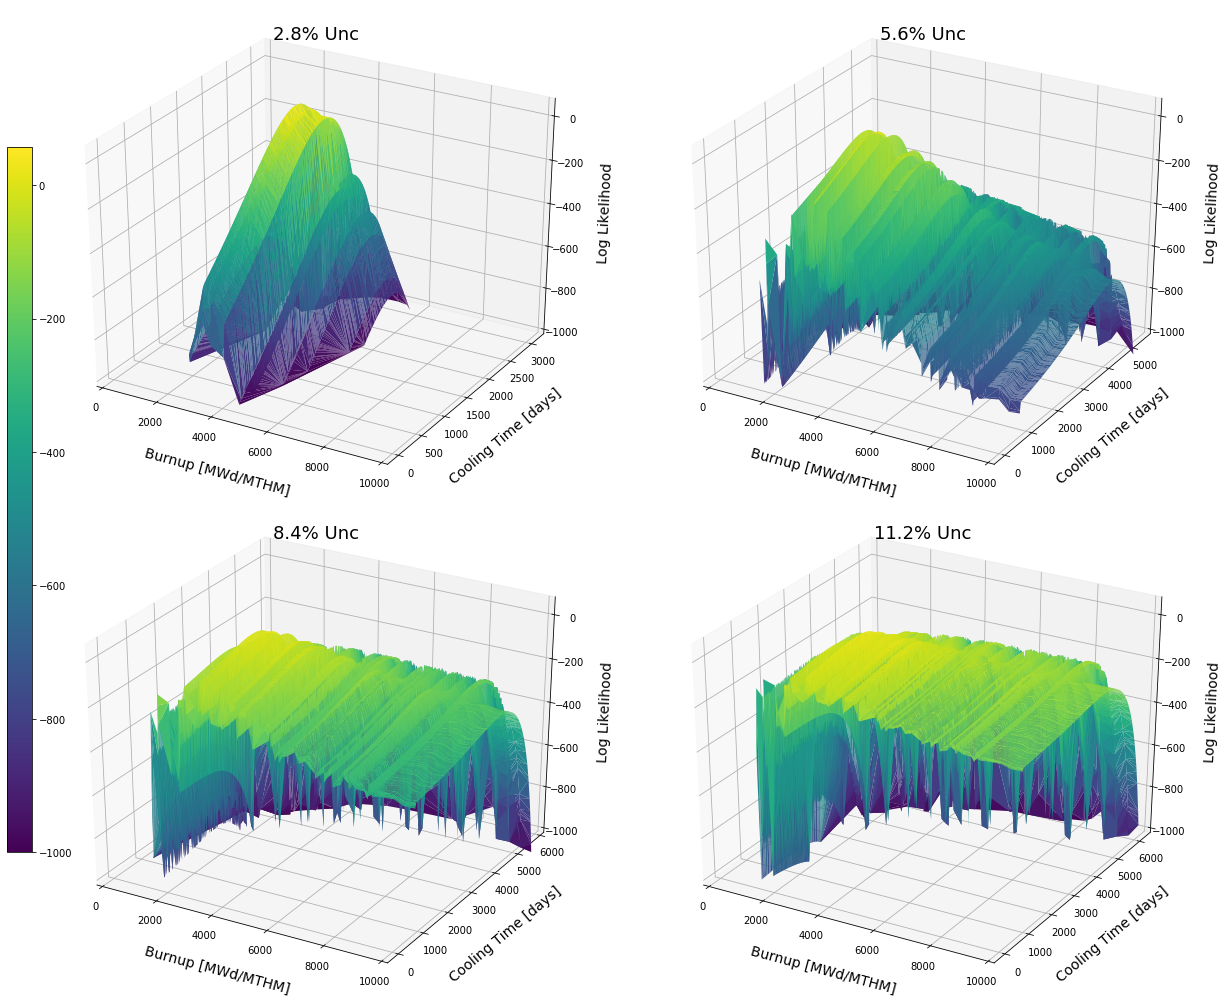

In [200]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))